# Online Shoppers Purchasing Intention
### *Machine Learning Project*, UWr 2024/2025

*   Denys Tsebulia 351322,
*   Mafalda Costa 351255,
*   Mariana Carvalho 351254.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV,KFold, RandomizedSearchCV, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours


## **Data analysis**

In [2]:
data = pd.read_csv("online_shoppers_intention.csv")
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

As it can be seen, the majority of the data consists of numerical features. However, there are 8 categorical features: 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend' and 'Revenue'. To utilize these features in our models, we will need to convert them into numerical representations.

To **convert 'Revenue', the target feature, into a numerical representation**, we can update the values using the following:

In [5]:
data["Revenue"] = data["Revenue"].apply(lambda x: 1 if x == True else 0)

### **Separating target, categorical and numerical features**

In [6]:
target="Revenue"
categorical_features=["OperatingSystems", "Browser", "Region", "TrafficType", "VisitorType", "Weekend", "Month"]
numerical_features=data.columns.drop(categorical_features).drop(target)

### **Distribution of 'Revenue'**

To visualize the distribution of the target feature 'Revenue', we use a count plot. This plot displays the number of occurrences for each class in the 'Revenue' feature.

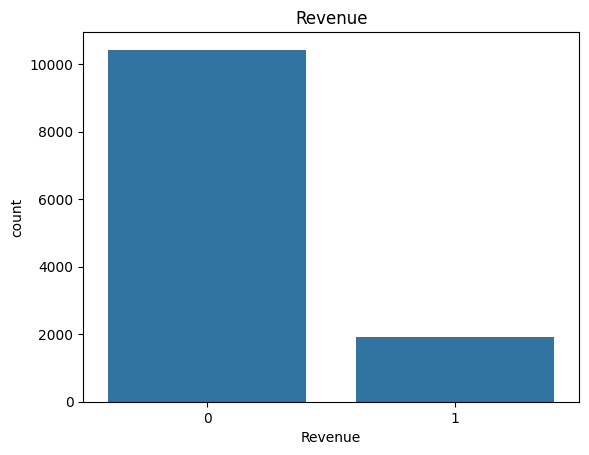

In [7]:
sb.countplot(x=target,data=data)
plt.title("Revenue")
plt.show()

We can observe an imbalance between the two classes of the target feature. The number of instances labeled as 0 ('False') is significantly larger than the number of instances labeled as 1 ('True').
This can potentially affect the performance of certain machine learning models, and appropriate techniques such as defining class weights, oversampling and undersampling are required to address this issue.

### **NULL values**

In [8]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

### **Correlation Analysis**

To explore the relationships between all the numerical features, we generate a heatmap:

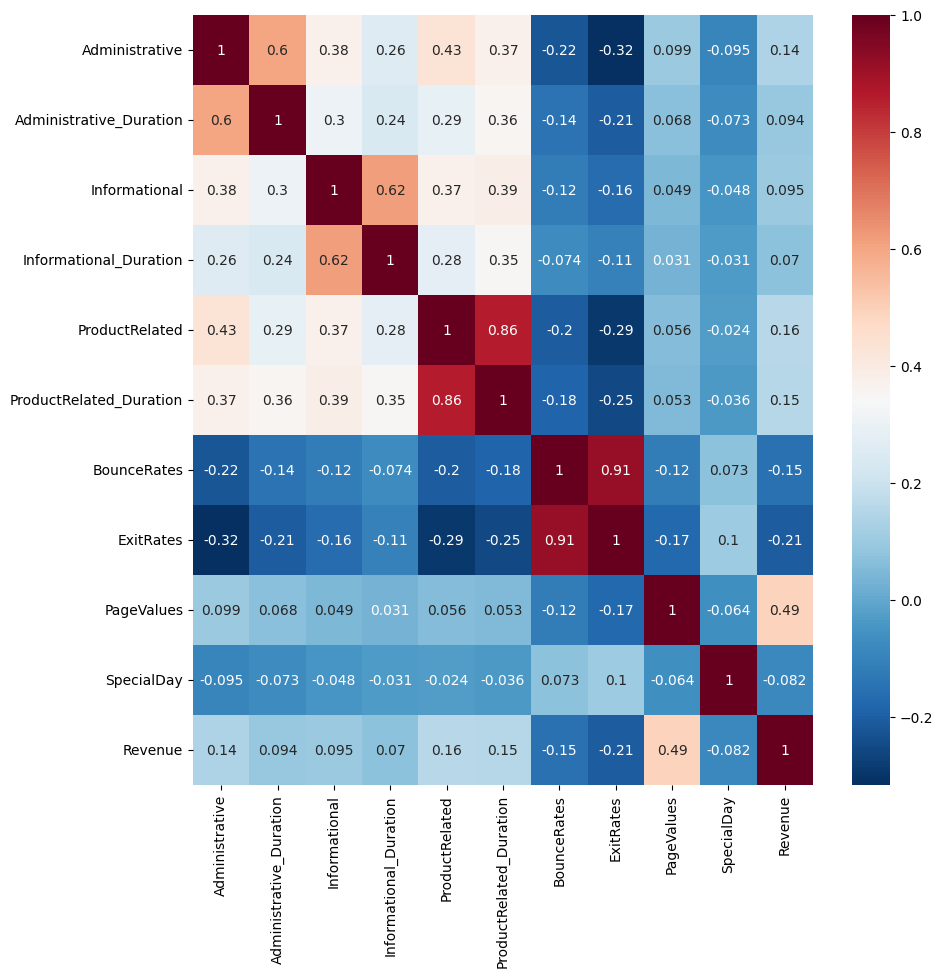

In [9]:
temp_data = numerical_features.append(pd.Index([target])) # created Index object to match the numerical features
fig, ax = plt.subplots(figsize=(10, 10))
sb.heatmap(data[temp_data].corr(), annot=True, cmap="RdBu_r")
plt.show()

Based on the heatmap, the analysis yields the following observations:
- There is **generally very little correlation** among the features.
- There are a few cases of **high correlation** (|corr| >= 0.7):
    - BounceRates & ExitRates (0.9).
    - ProductRelated & ProductRelated_Duration (0.86).
- There are **moderate correlations** (0.3 < |corr| < 0.7):
    - Among the following features: Administrative, Administrative_Duration, Informational, Informational_Duration, ProductRelated, and ProductRelated_Duration.
    - And between PageValues and Revenue.

To further visualize the relationships between the features, we generate a pairplot for each pair of features, where each session is represented through a purchase (in orange) or no purchase (blue):

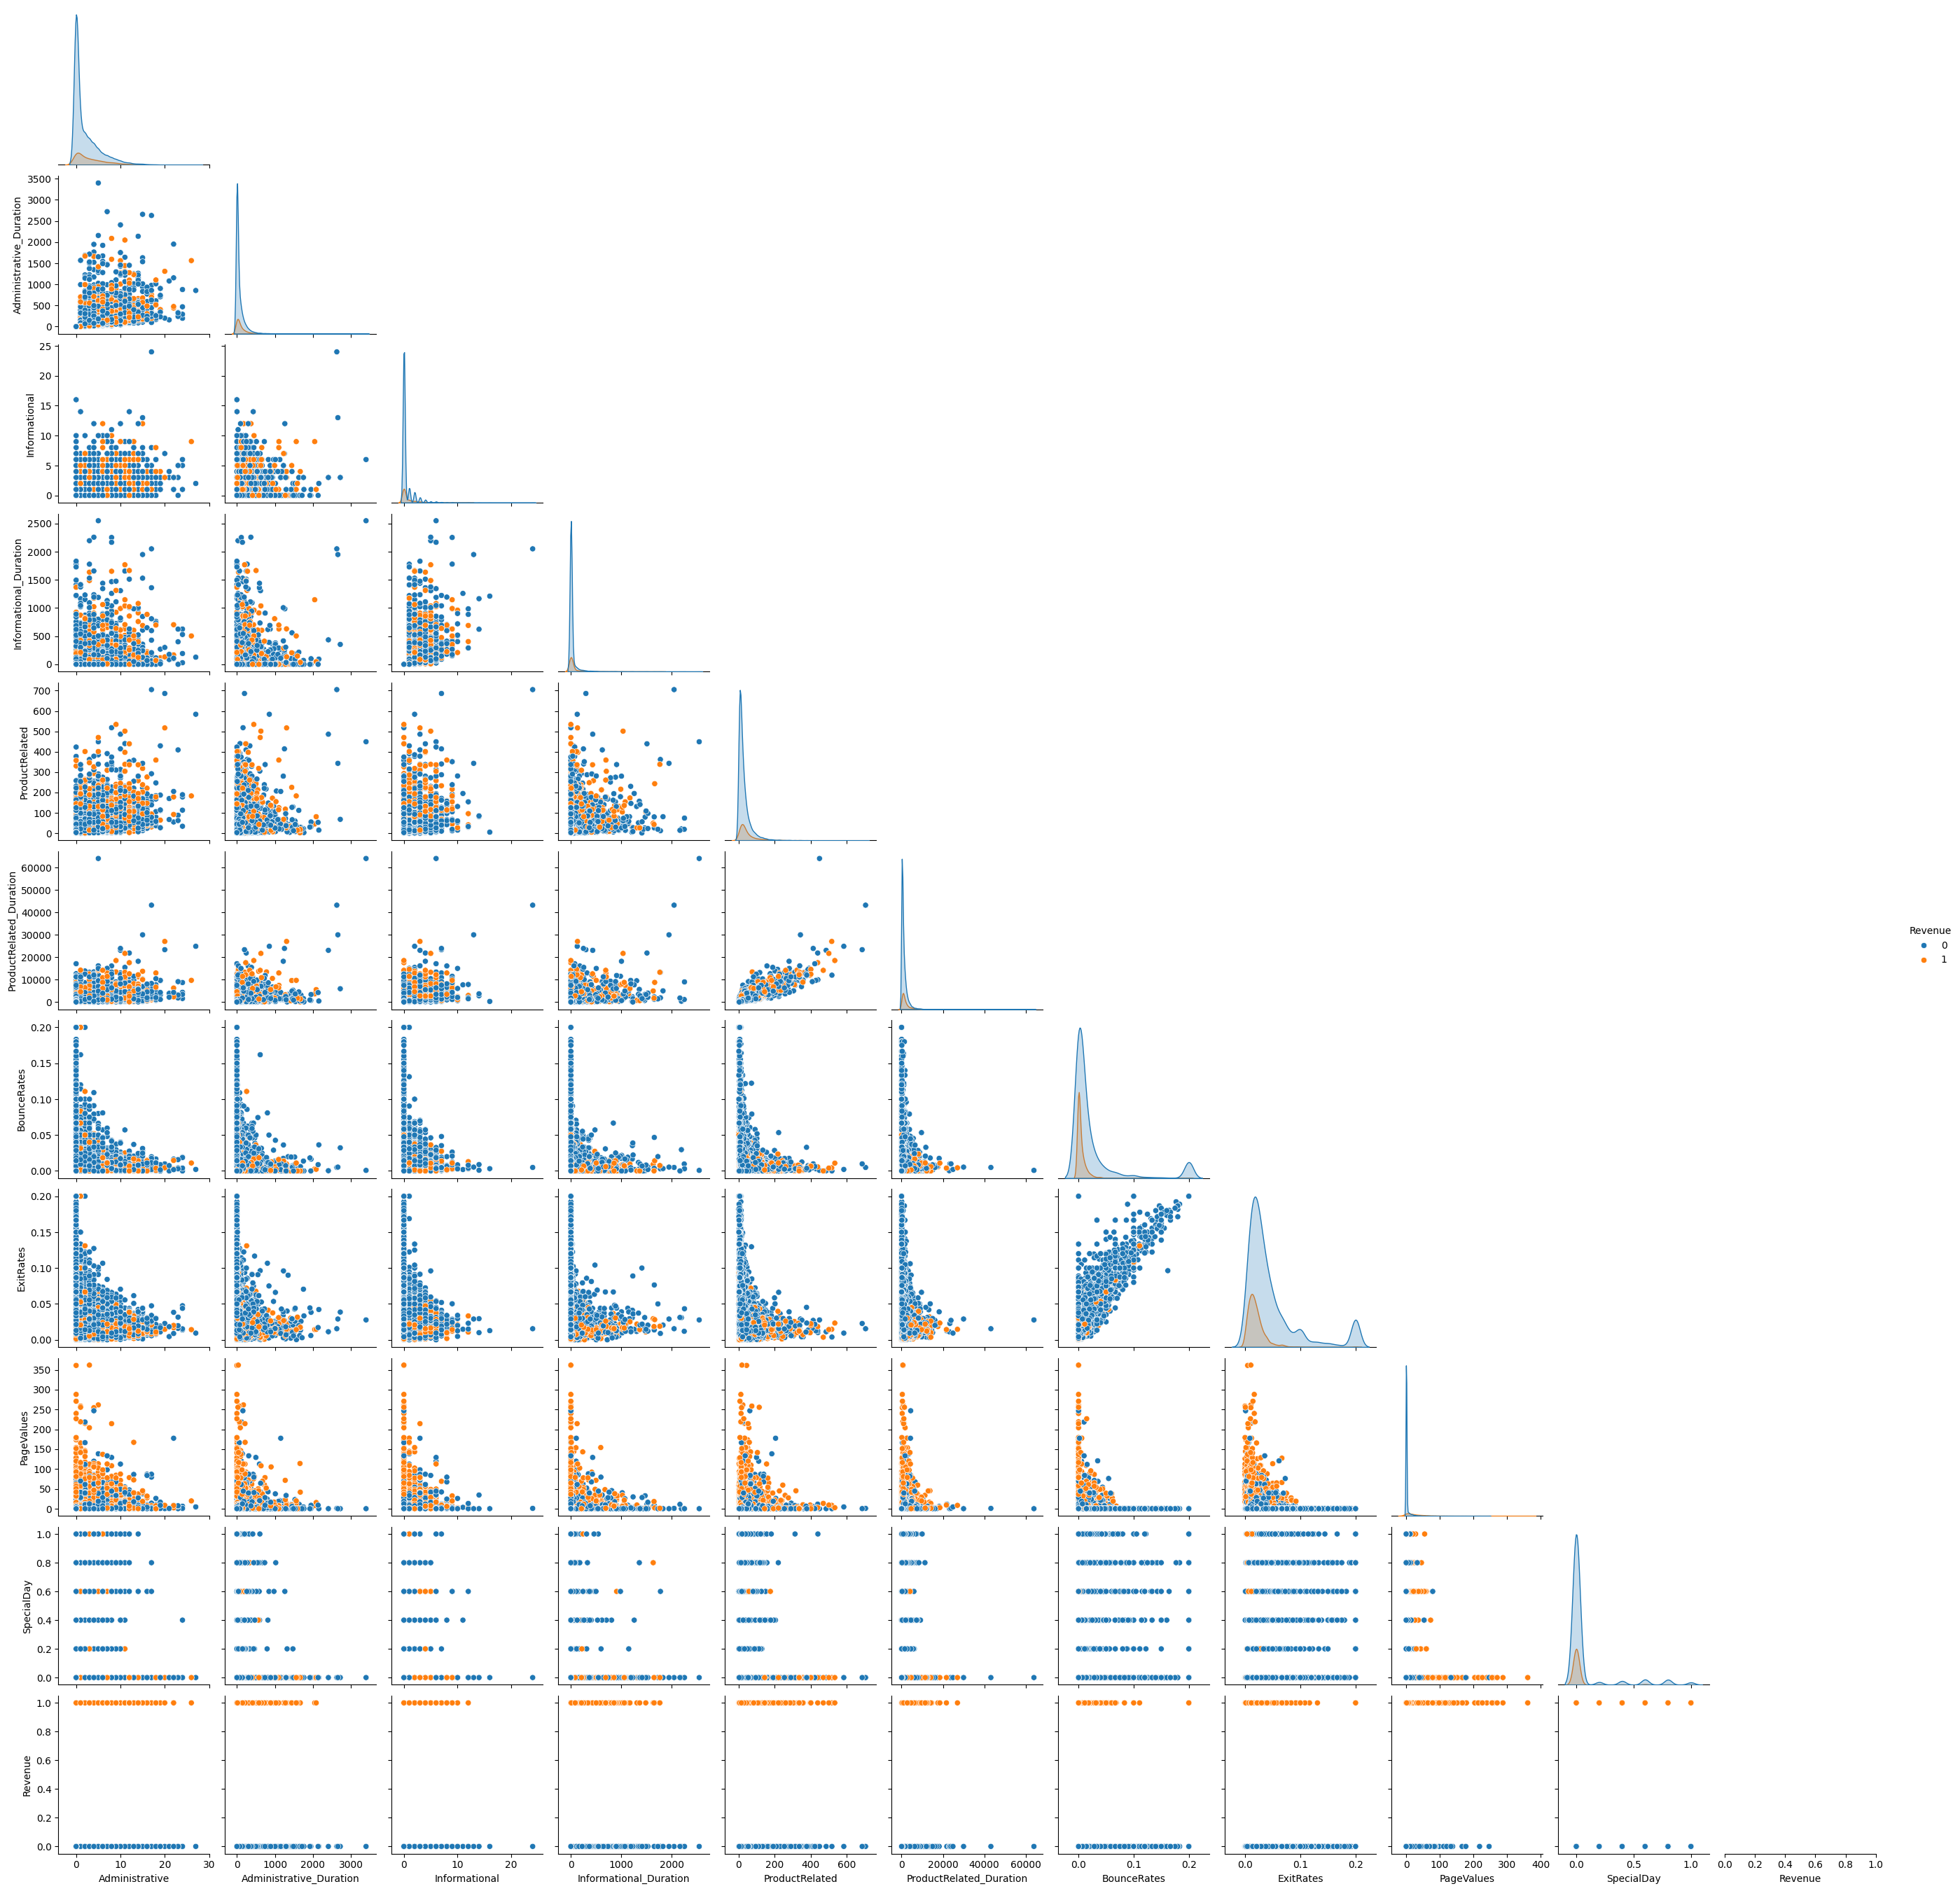

In [10]:
sb.pairplot(data, hue='Revenue', vars=numerical_features.append(pd.Index([target])), corner=True)

From the pairplot, the following observations can be made:
- There is no strong correlation between 'Revenue' and any other feature.
- Notably, there is a strong negative correlation between PageValues and other features shown in the plot.
- We can also see that the there are a few outliers present in the data that may need to be addressed.

### **Duplicate rows**

In [11]:
print("Total number of duplicate rows: ", data.duplicated().sum())

duplicates = data[data.duplicated()]
print("Duplicate rows:")
print(duplicates)

Total number of duplicate rows:  125
Duplicate rows:
       Administrative  Administrative_Duration  Informational  \
158                 0                      0.0              0   
159                 0                      0.0              0   
178                 0                      0.0              0   
418                 0                      0.0              0   
456                 0                      0.0              0   
...               ...                      ...            ...   
11934               0                      0.0              0   
11938               0                      0.0              0   
12159               0                      0.0              0   
12180               0                      0.0              0   
12185               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
158                       0.0               1                      0.0   
159               

## **Data pre-processing**

### **Remove duplicate rows**

In [12]:
data.drop_duplicates(inplace=True)
print("Total number of duplicate rows: ", data.duplicated().sum())

Total number of duplicate rows:  0


### **Outliers analysis**

Outliers are anomalies within the dataset and are rare occurrences.
In this problem, we can think, for example, of a situation where the user accidentally leaves their desktop open on a product page, only to return half an hour later. The website's analytics would register this as the user spending half an hour only reading the product page - a highly unlikely scenario. Such events are not representative of typical user behavior.


To analyise the outliers, we can look at the pairplot above and the generated boxplots (for each numerical feature, grouped by the 'Revenue' target variable) below.

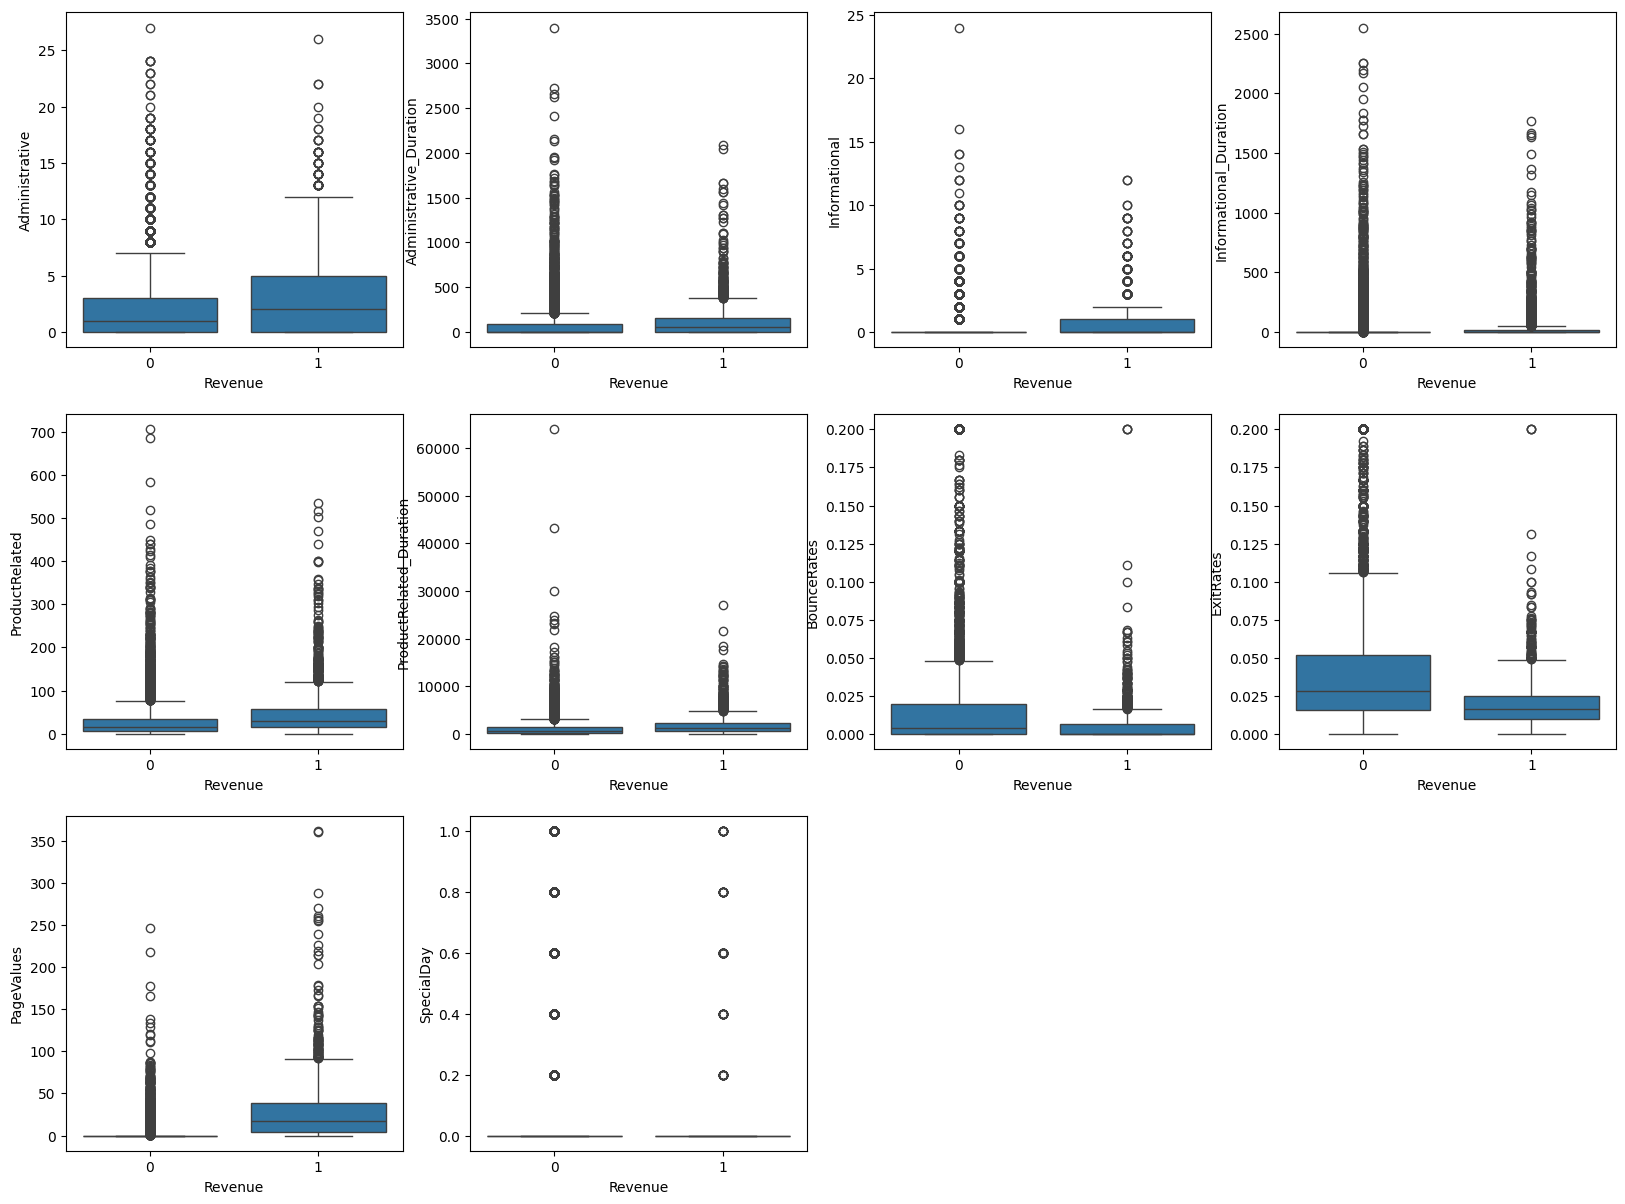

In [13]:
plt.figure(figsize=(20, 20))

for i, collumn in enumerate(numerical_features):
    plt.subplot(4, 4, i+1)
    sb.boxplot(data=data, x=target, y=collumn)
plt.show()

In [14]:
'''import matplotlib.cbook as cbook

plt.figure(figsize=(20, 20))

for i, column in enumerate(numerical_features):
    stats = {}
    stats = cbook.boxplot_stats(data[column], labels=[column])[0]

    # set the 2nd and 98th percentiles as the box edges
    stats['q1'], stats['q3'] = np.percentile(data[column], [2, 98])
    stats['iqr'] = stats['q3'] - stats['q1']  # update IQR

    # recompute whiskers
    outlier_threshold = 1.5
    stats['whislo'] = np.min(data[column][data[column] >= stats['q1'] - outlier_threshold * stats['iqr']])
    stats['whishi'] = np.max(data[column][data[column] <= stats['q3'] + outlier_threshold * stats['iqr']])

    # update outliers
    stats['fliers'] = data[column][(data[column] < stats['whislo']) | (data[column] > stats['whishi'])].tolist()

    plt.subplot(4, 4, i + 1)
    fig, ax = plt.subplots()
    ax.bxp([stats], showfliers=True)
    ax.set_title(column)

plt.show() '''

"import matplotlib.cbook as cbook\n\nplt.figure(figsize=(20, 20))\n\nfor i, column in enumerate(numerical_features):\n    stats = {}\n    stats = cbook.boxplot_stats(data[column], labels=[column])[0]\n\n    # set the 2nd and 98th percentiles as the box edges\n    stats['q1'], stats['q3'] = np.percentile(data[column], [2, 98])\n    stats['iqr'] = stats['q3'] - stats['q1']  # update IQR\n\n    # recompute whiskers\n    outlier_threshold = 1.5\n    stats['whislo'] = np.min(data[column][data[column] >= stats['q1'] - outlier_threshold * stats['iqr']])\n    stats['whishi'] = np.max(data[column][data[column] <= stats['q3'] + outlier_threshold * stats['iqr']])\n\n    # update outliers\n    stats['fliers'] = data[column][(data[column] < stats['whislo']) | (data[column] > stats['whishi'])].tolist()\n\n    plt.subplot(4, 4, i + 1)\n    fig, ax = plt.subplots()\n    ax.bxp([stats], showfliers=True)\n    ax.set_title(column)\n\nplt.show() "

We can observe that there are outliers present in all features, for both 'Revenue' categories, and that the median and IQR values really vary within the same feature.

To remove the outliers, we used the calculation Interquartille Range (IQR) by calculating the percentile for each of the features. We have decided to cut off only very "far out" information from the dataset thus including majority of the data, which is between the 2nd
percentile and 98th percentile. This is because there is a risk of losing important information if too much data is removed.


Number of outliers removed: 113


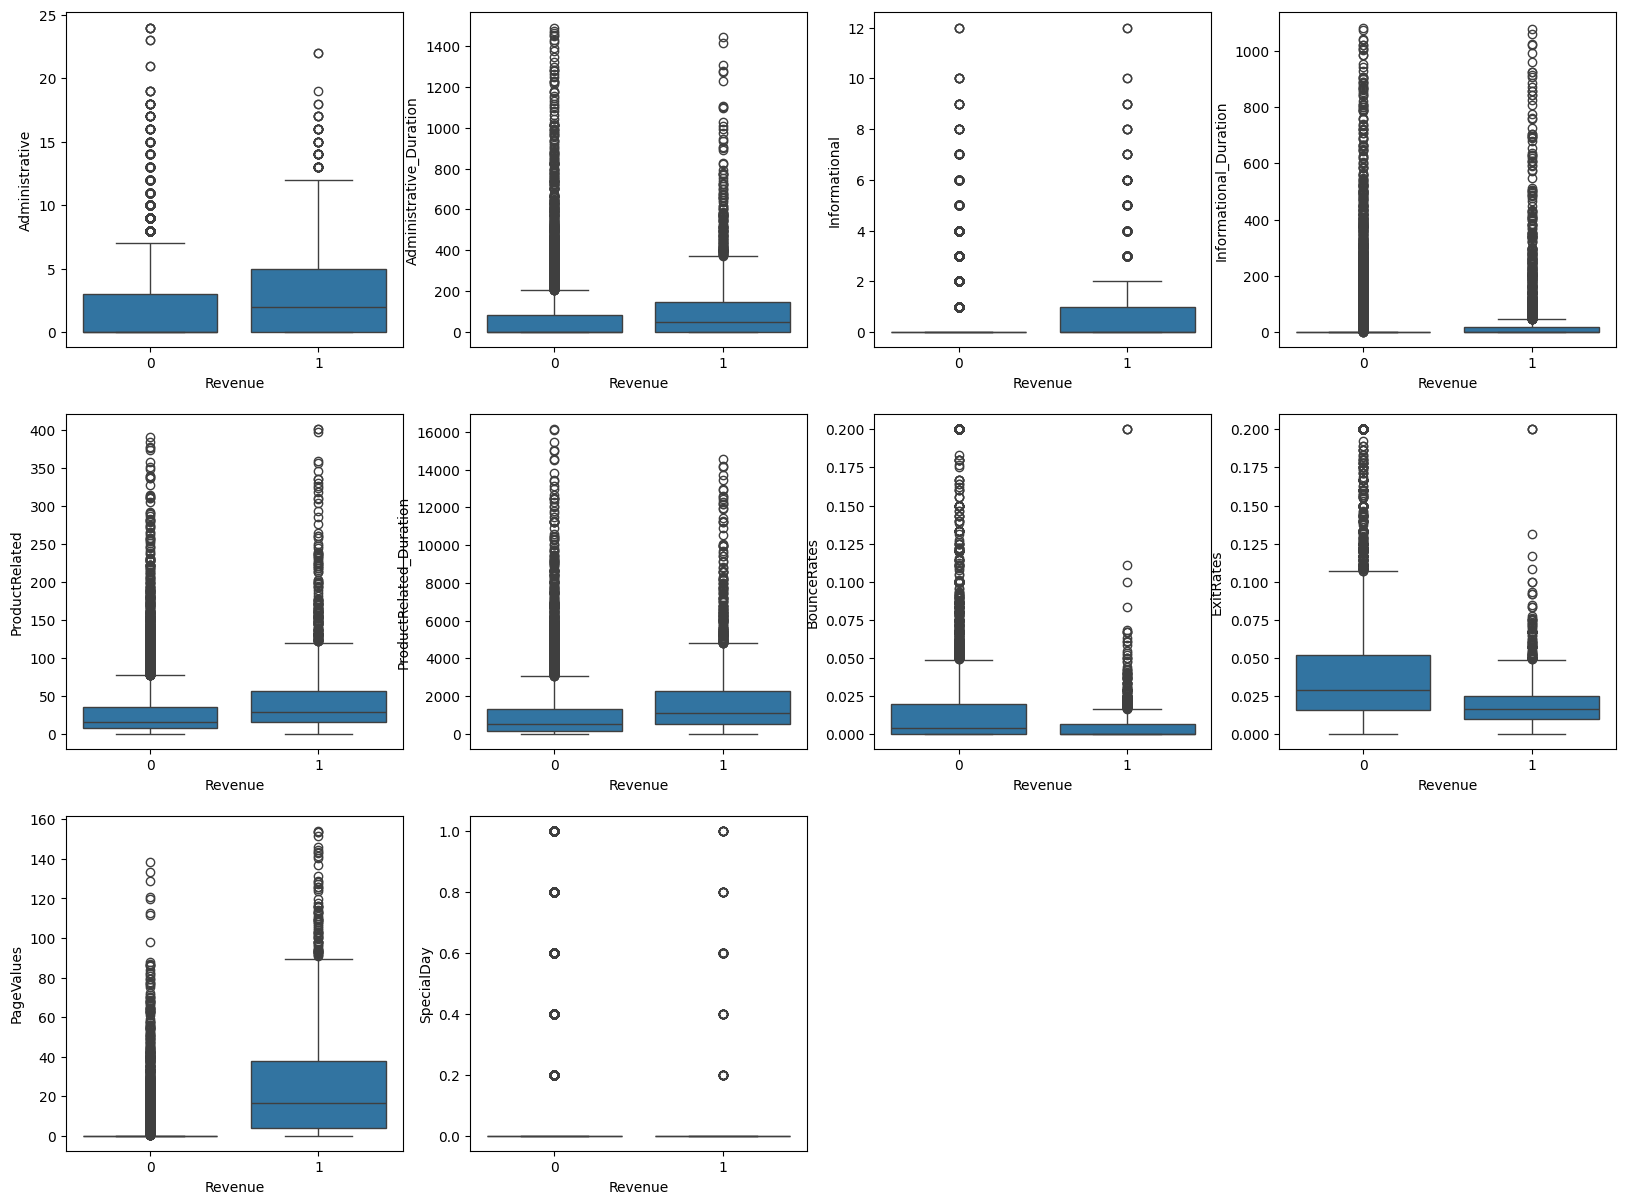

In [15]:
Q1 = data[numerical_features].quantile(0.02)
Q3 = data[numerical_features].quantile(0.98)
IQR = Q3 - Q1

outlier_threshold = 1.5 # standard threshold

# identify outliers for each feature --> create a boolean data frame where a 'True' indicates an outlier in the corresponding feature and row
outliers = (data[numerical_features] < (Q1 - outlier_threshold * IQR)) | (data[numerical_features] > (Q3 + outlier_threshold * IQR))

# remove outliers from the dataset --> only rows where no features are flagged as outliers are kept
data_no_outliers = data[numerical_features][~(outliers.any(axis=1))]

# print the number of removed outliers
num_outliers_removed = len(data) - len(data_no_outliers)
print("Number of outliers removed:", num_outliers_removed)

# replace the original data with the no outliers data
data[numerical_features] = data_no_outliers

# drop rows with missing values --> removing rows with outliers of the numerical columns will leave gaps (NaN) in the other columns
data.dropna(inplace=True)

plt.figure(figsize=(20, 20))
for i, collumn in enumerate(numerical_features):
    plt.subplot(4, 4, i+1)
    sb.boxplot(data=data, x=target, y=collumn)
plt.show()

### **Encode categorical features**

We first deal with the boolean feature 'Weekend', by transforming its value to 1 ('True') and 0 ('False').

In [16]:
data["Weekend"] = data["Weekend"].apply(lambda x: 1 if x == True else 0)
categorical_features.remove("Weekend")

To handle the rest of the categorical features in our dataset, we use OneHotEnconder. This transforms the categorical features into numerical representations, and, as a result, the 8 categorical features are expanded into 66 attributes.

In [17]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
for feature in categorical_features:
    onehotarray = encoder.fit_transform(data[[feature]]).toarray()
    items = [f'{feature}_{item}' for item in encoder.categories_[0]]
    data[items] = onehotarray

data=data.drop(categorical_features, axis=1)
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Scaler**

Firstly, we exclude the target feature from the set of features.

In [18]:
features=list(data.columns)
features.remove('Revenue')
features

['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
 'Weekend',
 'OperatingSystems_1',
 'OperatingSystems_2',
 'OperatingSystems_3',
 'OperatingSystems_4',
 'OperatingSystems_5',
 'OperatingSystems_6',
 'OperatingSystems_7',
 'OperatingSystems_8',
 'Browser_1',
 'Browser_2',
 'Browser_3',
 'Browser_4',
 'Browser_5',
 'Browser_6',
 'Browser_7',
 'Browser_8',
 'Browser_9',
 'Browser_10',
 'Browser_11',
 'Browser_12',
 'Browser_13',
 'Region_1',
 'Region_2',
 'Region_3',
 'Region_4',
 'Region_5',
 'Region_6',
 'Region_7',
 'Region_8',
 'Region_9',
 'TrafficType_1',
 'TrafficType_2',
 'TrafficType_3',
 'TrafficType_4',
 'TrafficType_5',
 'TrafficType_6',
 'TrafficType_7',
 'TrafficType_8',
 'TrafficType_9',
 'TrafficType_10',
 'TrafficType_11',
 'TrafficType_12',
 'TrafficType_13',
 'TrafficType_14',
 'TrafficType_15',
 'TrafficType_16',
 'Traff

We apply feature scaling to our subsets, using MinMaxScaler. Feature scaling is particularly beneficial for models that are sensitive to the magnitude of features.

In [19]:
from sklearn.preprocessing import MinMaxScaler

# (X - X_min) / (X_max - X_min)
scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns=data.columns)
scaled_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0.0,0.0,0.0,0.0,0.002494,0.000000,1.00,1.00,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.004988,0.003966,0.00,0.50,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.002494,0.000000,1.00,1.00,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.004988,0.000165,0.25,0.70,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.024938,0.038883,0.10,0.25,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Feature selection**

In order to optimize our model's performance and reduce unnecessary complexity, we performed feature selection. With a total of 75 input features, it was essential to identify the features that have the most significant impact on the 'Revenue' and remove those that have a negligible effect.

This function performs feature selection using the chi-squared test as the scoring function. It selects the top 'n' features based on their scores.

In [20]:
from sklearn.feature_selection import SelectKBest, chi2

#chi2 (from wikipedia):
#In simpler terms, this test is primarily used to examine
#whether two categorical variables are independent in influencing the test statistic .

def feature_selection(features, n, data):
    selector = SelectKBest(score_func=chi2, k=n)
    fit=selector.fit(data[features],data[target])

    selected_feature_indices = selector.get_support(indices=True)

    selected_features = [data[features].columns[i] for i in selected_feature_indices]
    return selected_features

feature_dict_data = {}
for i in range(2, int(len(features))):
    feature_dict_data[i] = feature_selection(features, i, data)

for key in list(feature_dict_data.keys())[:5]:
    print(f"Key: {key}, Value: {feature_dict_data[key]}")

Key: 2, Value: ['ProductRelated_Duration', 'PageValues']
Key: 3, Value: ['Administrative_Duration', 'ProductRelated_Duration', 'PageValues']
Key: 4, Value: ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'PageValues']
Key: 5, Value: ['Administrative_Duration', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'PageValues']
Key: 6, Value: ['Administrative', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'PageValues']


### **Resampling**

In [21]:
data.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
       'Revenue', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5',
       'OperatingSystems_6', 'OperatingSystems_7', 'OperatingSystems_8',
       'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Browser_10',
       'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3',
       'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
       'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11',
       'TrafficType_12', 'TrafficType_13', 'TrafficT

In [22]:
data[target]

0        0
1        0
2        0
3        0
4        0
        ..
12325    0
12326    0
12327    0
12328    0
12329    0
Name: Revenue, Length: 12092, dtype: int64

In [23]:
#implement weighted-based resampling
class_counts = np.bincount(data[target])
class_weights = len(data) / (len(class_counts) * class_counts)
weights_train = np.array([class_weights[label] for label in data[target]])
weights_train_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class counts:", class_counts)
print("Class weights:", class_weights)

Class counts: [10223  1869]
Class weights: [0.59141152 3.23488497]


In [ ]:
smote_enn = SMOTEENN(sampling_strategy=0.7, enn=EditedNearestNeighbours(sampling_strategy='majority'))
resampled_data, resampled_target = smote_enn.fit_resample(data[features], data[target])

# print the number of samples in each class after resampling
print("Class counts after resampling:", np.bincount(resampled_target))

Class counts after resampling: [7306 7156]


## **Models**

#### k-fold and evaluation

In [35]:
def training_and_predictions_with_KFold(Algorithm, name,num_features, data=data, draw_confusion_matrix=False):
    kf =KFold(n_splits=10)
    predictions = []
    results = []
    prediction_probs = []  # To store prediction probabilities
    selected_features=feature_dict_data[num_features]
    all_inputs = data[selected_features].values

    all_labels = data[target].values

    for i, (train_index, test_index) in enumerate(kf.split(all_inputs, all_labels)):
        # Split the data into training and testing sets
        X_train, X_test = all_inputs[train_index], all_inputs[test_index]
        y_train, y_test = all_labels[train_index], all_labels[test_index]
        Algorithm.fit(X_train, y_train)
        predictions.append(Algorithm.predict(X_test))
        results.append(y_test)
        if(hasattr(Algorithm, "predict_proba")):
            prediction_probs.append(Algorithm.predict_proba(X_test)[:, 1])

    all_predictions = np.concatenate(predictions)
    all_results = np.concatenate(results)
    if(hasattr(Algorithm, "predict_proba")):
        all_prediction_probs = np.concatenate(prediction_probs)

    #calculates the metrics
    accuracy = accuracy_score(all_results, all_predictions)
    precision = precision_score(all_results, all_predictions)
    recall = recall_score(all_results, all_predictions)
    f1 = f1_score(all_results, all_predictions)

    #prints the metrics, confusion matrix and ROC curve
    if draw_confusion_matrix:
        df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recall],
                       "Precision_score"       : [precision],
                       "F1_score"        : [f1],
                      })
        conf_matrix = confusion_matrix(all_results, all_predictions)
        plt.figure(figsize=(10, 5))  # Increase figure size for better visibility
        plt.subplot(1, 2, 1)  # First subplot for confusion matrix
        sb.heatmap(conf_matrix, cmap='Blues', annot=True, xticklabels=data['Revenue'].unique(), yticklabels=data['Revenue'].unique())
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title("Confusion matrix for "+name)

        # ROC curve
        plt.subplot(1, 2, 2)  # Second subplot for ROC curve
        fpr, tpr, thresholds = roc_curve(all_results, all_prediction_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic for '+name)
        plt.legend(loc="lower right")
        plt.tight_layout()  # Adjust subplot parameters to give specified padding
        plt.show()

        # Return both DataFrame and ROC curve metrics
        return df, {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
    return accuracy, precision, recall, f1

In [36]:
def features_num_training_and_predictions_with_KFold(Algorithm, name, data=data):
    accuracy_scores=[]
    precision_scores=[]
    recall_scores=[]
    f1_scores=[]
    size_features=[]
    max_f1=0
    max_precision=0
    num_features=0
    for i in range(2, int(len(features))):
        accuracy_score, precision_score, recall_score, f1_score=training_and_predictions_with_KFold(Algorithm, name, i, data, False)
        accuracy_scores.append(accuracy_score)
        precision_scores.append(precision_score)
        recall_scores.append(recall_score)
        f1_scores.append(f1_score)
        size_features.append(i)
        if(f1_score>max_f1):
            max_f1=f1_score
            max_precision=precision_score
            num_features=i
        if(f1_score==max_f1 and precision_score>max_precision):
            max_precision=precision_score
            num_features=i

    plt.figure()
    plt.plot(size_features, accuracy_scores, label="accuracy")
    plt.plot(size_features, precision_scores, label="precision")
    plt.plot(size_features, recall_scores, label="recall")
    plt.plot(size_features, f1_scores, label="f1")
    plt.xlabel("Number of features")
    plt.ylabel("Score")
    plt.title("Scores for different number of features of "+name)
    plt.legend()
    plt.show()
    print(f"Features chosen: {feature_dict_data[num_features]}")
    return num_features


In [37]:
roc_curve_data = {}
roc_curve_data_resampled = {}

results_training = {}
results_training_resampled ={}

In [ ]:
cross_validation = KFold(n_splits=10)

### Random Forest

In [ ]:
random_forest_classifier = RandomForestClassifier()

grid search on Random Forest (without class weights)

In [ ]:
random_forest_parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [10,100],
    'max_depth': [ 4, 5, 6, 9, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': ['log2', 2, 4],
    'max_leaf_nodes': [None, 2,  5],
    'min_samples_leaf': [ 2, 4,],
    'min_samples_split': [2],
    'class_weight': ['balanced', 'balanced_subsample', None, weights_train_dict],
    'random_state': [100],
    'ccp_alpha': [ 0.1, 0.2,0.4, 0.5]
}

random_forest_grid_search = GridSearchCV( random_forest_classifier, param_grid=random_forest_parameter_grid, cv=cross_validation, scoring='f1')
random_forest_grid_search.fit(data[features].values, data[target].values)

print('Best score for Random Forest: {}'.format(random_forest_grid_search.best_score_))
print('Best parameters for Random Forest: {}'.format(random_forest_grid_search.best_params_))

In [ ]:
random_forest_parameter_grid_resampled = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [10,100],
    'max_depth': [ 4, 5, 6, 9, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': ['log2', 2, 4],
    'max_leaf_nodes': [None, 2,  5],
    'min_samples_leaf': [ 2, 4,],
    'min_samples_split': [2],
    'random_state': [100],
    'ccp_alpha': [ 0.1, 0.2,0.4, 0.5]
}

random_forest_grid_search_resampled = GridSearchCV( random_forest_classifier, param_grid=random_forest_parameter_grid_resampled, cv=cross_validation, scoring='precision') 
random_forest_grid_search_resampled.fit(resampled_data[features].values, resampled_data[target].values)

print('Best score for Random Forest: {}'.format(random_forest_grid_search.best_score_))
print('Best parameters for Random Forest: {}'.format(random_forest_grid_search.best_params_))

In [ ]:
# random forest classifier
random_forest_classifier = random_forest_grid_search.best_estimator_

# random forest classifier with resampled data
random_forest_classifier_resampled = random_forest_grid_search_resampled.best_estimator_

In [ ]:
# retrieving the best number of features for this classifier
num_features_random_forest=features_num_training_and_predictions_with_KFold(random_forest_classifier, "Random Forest", data=data)
print("Number of features Random Forest: ", num_features_random_forest)

num_features_random_forest_resampled=features_num_training_and_predictions_with_KFold(random_forest_classifier_resampled, "Random Forest with Resampled Data", resampled_data)
print("Number of features Random Forest with Resampled Data: ", num_features_random_forest_resampled)

In [ ]:
# random forest
# get evaluation metrics and ROC curve
model_RF_Kfold, roc_curve_RF = training_and_predictions_with_KFold(random_forest_classifier, "Random Forest", num_features_random_forest, data, draw_confusion_matrix=True)

# random forest with resampled data
model_RF_Kfold_resampled, roc_curve_RF_resampled = training_and_predictions_with_KFold(random_forest_classifier_resampled, "Random Forest with Resampled Data", num_features_random_forest_resampled, resampled_data, draw_confusion_matrix=True)

# plot confusion matrix and ROC curve
roc_curve_data["Random Forest"] = roc_curve_RF
roc_curve_data_resampled["Random Forest Resampling"] = roc_curve_RF_resampled

results_training["Random Forest"] = model_RF_Kfold
results_training_resampled["Random Forest Resampling"] = model_RF_Kfold_resampled

# table with model performances
model_performances = pd.concat([model_RF_Kfold, model_RF_Kfold_resampled],axis = 0).reset_index()
model_performances = model_performances.drop(columns = "index",axis =1) 


### Decision tree

In [ ]:
decision_tree_classifier = DecisionTreeClassifier()

In [ ]:
parameter_grid_decision_tree = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [3, 4, 5, 6], 
    'max_leaf_nodes': [None, 2, 3],
    'max_features': [None, 'sqrt', 'log2', 2, 4], 
    'min_samples_split': [2, 3, 4],
    'class_weight': [None, 'balanced', weights_train_dict],
    'random_state': [None, 42, 100],
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
      }

grid_search_decision_tree = GridSearchCV( decision_tree_classifier,
                        param_grid=parameter_grid_decision_tree,
                        cv=cross_validation,
                        scoring='f1')
grid_search_decision_tree.fit(data[features].values, data[target].values)

print('Best score of decision tree: {}'.format(grid_search_decision_tree.best_score_))
print('Best parameters of decision tree: {}'.format(grid_search_decision_tree.best_params_))

In [ ]:
parameter_grid_decision_tree_resampled = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [3, 4, 5, 6], 
    'max_leaf_nodes': [None, 2, 3],
    'max_features': [None, 'sqrt', 'log2', 2, 4], 
    'min_samples_split': [2, 3, 4],
    'random_state': [None, 42, 100],
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

grid_search_decision_tree_resampled = GridSearchCV( decision_tree_classifier,
                        param_grid=parameter_grid_decision_tree_resampled,
                        cv=cross_validation,
                        scoring='precision')

# apply grid search with class weights
grid_search_decision_tree_resampled.fit(resampled_data[features].values, resampled_data[target].values)

print('Best score of decision tree with class weights: {}'.format(grid_search_decision_tree_resampled.best_score_))
print('Best parameters of decision tree with class weights: {}'.format(grid_search_decision_tree_resampled.best_params_))

In [129]:
decision_tree_classifier = grid_search_decision_tree.best_estimator_
decision_tree_classifier_resampled = grid_search_decision_tree_resampled.best_estimator_

In [ ]:
# decision tree
num_features_decision_tree = features_num_training_and_predictions_with_KFold(decision_tree_classifier, "Decision Tree", data)
print("Number of features for Decision Tree: ", num_features_decision_tree)

# decision tree with class weights
num_features_decision_tree_resampled=features_num_training_and_predictions_with_KFold(decision_tree_classifier_resampled, "Decision Tree with Resampled Data", resampled_data)
print("Number of features for Decision Tree with Resampled Data: ", num_features_decision_tree_resampled)

In [ ]:
# decision tree
# get evaluation metrics
model_DT_Kfold, roc_curve_DT = training_and_predictions_with_KFold(decision_tree_classifier, "Decision Tree", num_features_decision_tree, data, draw_confusion_matrix=True)

# decision tree with class weights
model_DT_Kfold_resampled, roc_curve_DT_resampled = training_and_predictions_with_KFold(decision_tree_classifier_resampled, "Decision Tree with Resampled Data", num_features_decision_tree_resampled, resampled_data, draw_confusion_matrix=True)

# plot confusion matrix and ROC curve
roc_curve_data["Decision Tree"] = roc_curve_DT
roc_curve_data_resampled["Decision Tree with Resampled Data"] = roc_curve_DT_resampled

results_training["Decision Tree"] = model_DT_Kfold
results_training_resampled["Decision Tree with Resampled Data"] = model_DT_Kfold_resampled

# table with model performances
model_performances = pd.concat([model_DT_Kfold, model_DT_Kfold_resampled],axis = 0).reset_index()
model_performances = model_performances.drop(columns = "index",axis =1)
model_performances

### XGBoost

In [43]:
scaler.fit(resampled_data)
scaled_resampled_data = pd.DataFrame(scaler.transform(resampled_data), columns=resampled_data.columns)
scaled_resampled_data.head()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Revenue


In [ ]:
xgb = XGBClassifier()

In [ ]:
scale_pos_weight = round(np.bincount(data[target])[0] / np.bincount(data[target])[1])

print(f"scale_pos_weight parameter: {scale_pos_weight}")

In [ ]:
xgb_parameter_grid = {'n_estimators': [50],
                    'max_depth': [3, 5, 10, 50, 100],
                    'learning_rate': [0.1],
                    'reg_alpha': [0.5],
                    'reg_lambda': [0, 0.2, 0.5, 0.8],
                    'booster': ['gbtree'],
                    'objective': ['binary:logistic'],
                    'subsample': [0.5, 0.7, 1.0],
                    'colsample_bytree': [0.5, 1.0],
                    'gamma': [0, 1],
                    'scale_pos_weight' : [1, scale_pos_weight]  #default value is 1, for imbalanced data typical value is ratio of majority class to minority class
}

xgb_grid_search = GridSearchCV(xgb, param_grid=xgb_parameter_grid, cv=xgb_parameter_grid, scoring='f1')

xgb_grid_search.fit(scaled_data[features].values, scaled_data[target].values)

print('Best score: {}'.format(xgb_grid_search.best_score_))
print('Best parameters: {}'.format(xgb_grid_search.best_params_))
svm = SVC()

In [ ]:
xgb_parameter_grid_resampled = {'n_estimators': [50],
                    'max_depth': [3, 5, 10, 50, 100],
                    'learning_rate': [0.1],
                    'reg_alpha': [0.5],
                    'reg_lambda': [0, 0.2, 0.5, 0.8],
                    'booster': ['gbtree'],
                    'objective': ['binary:logistic'],
                    'subsample': [0.5, 0.7, 1.0],
                    'colsample_bytree': [0.5, 1.0],
                    'gamma': [0, 1],
}

xgb_resampled_grid_search = GridSearchCV(xgb, param_grid=xgb_parameter_grid_resampled, cv=cross_validation, scoring='precision')

xgb_resampled_grid_search.fit(scaled_resampled_data[features].values, scaled_resampled_data[target].values)

print('Best score: {}'.format(xgb_resampled_grid_search.best_score_))
print('Best parameters: {}'.format(xgb_resampled_grid_search.best_params_))

In [ ]:
# xgboost classifier
xgb_classifier = xgb_grid_search.best_estimator_

# xgboost classifier for resampled data
xgb_classifier_resampled = xgb_resampled_grid_search.best_estimator_


Best number of features

In [ ]:
# retrieving the best number of features for this classifier
num_features_xgboost =features_num_training_and_predictions_with_KFold(xgb_classifier, "XGBoost", scaled_data)
print("Number of features: ", num_features_xgboost)

num_features_xgboost_resample=features_num_training_and_predictions_with_KFold(xgb_classifier_resampled, "XGBoost Resampling", scaled_resampled_data)
print("Number of features resample: ", num_features_xgboost_resample)

Performance metrics: confusion matrix, ROC curve, accuracy, recall, precision and F1 score

In [ ]:
# xgboost
# get evaluation metrics and ROC curve
xgb_Kfold, roc_curve_XGB=training_and_predictions_with_KFold(xgb_classifier, "XGBoost", num_features_xgboost, scaled_data, draw_confusion_matrix=True)

# xgboost for resampled data
xgb_Kfold_resampling, roc_curve_XGB_resampling=training_and_predictions_with_KFold(xgb_classifier_resampled, "XGBoost Resampling", num_features_xgboost_resample, scaled_resampled_data, draw_confusion_matrix=True)

# plot confusion matrix and ROC curve
roc_curve_data["XGBoost"] = roc_curve_XGB
roc_curve_data_resampled["XGBoost Resampling"] = roc_curve_XGB_resampling

results_training["XGBoost"] = xgb_Kfold
results_training_resampled["XGBoost Resampling"] = xgb_Kfold_resampling

# table with model performances
model_performances = pd.concat([xgb_Kfold, xgb_Kfold_resampling],axis = 0).reset_index()
model_performances = model_performances.drop(columns = "index",axis =1) 
model_performances

### SVM

In [ ]:
parameter_grid_svm = {'C': [10, 100, 1000],
                  'kernel': ['poly', 'rbf'],
                  'gamma': [1, 0.1,0.01],
                  'coef0': [0.0, 0.1, 0.2],
                  'class_weight': [None, 'balanced', weights_train_dict],
                  }


grid_search_svm = GridSearchCV( svm,
                        param_grid=parameter_grid_svm,
                        cv=cross_validation,
                        scoring='f1')
    
grid_search_svm.fit(data[features].values, data[target].values)

print('Best score of SVM: {}'.format(grid_search_svm.best_score_))
print('Best parameters of SVM: {}'.format(grid_search_svm.best_params_))

In [ ]:
parameter_grid_svm_resampled = {'C': [10, 100, 1000],
                  'kernel': ['poly', 'rbf'],
                  'gamma': [1, 0.1,0.01],
                  'coef0': [0.0, 0.1, 0.2],
                  }

grid_search_svm_resampled = GridSearchCV( svm,
                        param_grid=parameter_grid_svm_resampled,
                        cv=cross_validation,
                        scoring='precision')

grid_search_svm_resampled.fit(resampled_data[features].values, resampled_data[target].values)

print('Best score of SVM with Resampled Data: {}'.format(grid_search_svm_resampled.best_score_))
print('Best parameters of SVM with Resampled Data: {}'.format(grid_search_svm_resampled.best_params_))

In [ ]:
svm_classifier = grid_search_svm.best_estimator_
svm_classifier_resampled = grid_search_svm_resampled.best_estimator_

In [ ]:
# svm
num_features_svm = features_num_training_and_predictions_with_KFold(svm_classifier, "SVM")
print("Number of features for SVM: ", num_features_svm)

# svm with class weights
num_features_svm_resampled = features_num_training_and_predictions_with_KFold(svm_classifier_resampled, "SVM with Resampled Data", data, weights_train)
print("Number of features for SVM with Resampled Data: ", num_features_svm_resampled)

In [ ]:
# get evaluation metrics of SVM
model_DT_Kfold, roc_curve_DT = training_and_predictions_with_KFold(svm_classifier, "SVM", num_features_svm,  data, draw_confusion_matrix=True)

# SVM with class weights
model_DT_Kfold_resampled , roc_curve_DT_resampled = training_and_predictions_with_KFold(svm_classifier_resampled, "SVM with Resampled Data", num_features_svm_resampled, data, draw_confusion_matrix=True)

# plot confusion matrix and ROC curve
roc_curve_data["SVM"] = roc_curve_DT
roc_curve_DT_resampled["SVM with Resampled Data"] = roc_curve_DT_resampled

results_training["SVM"] = model_DT_Kfold
results_training_resampled["SVM with Resampled Data"] = model_DT_Kfold_resampled

# table with model performances
model_performances = pd.concat([model_DT_Kfold, model_DT_Kfold_resampled],axis = 0).reset_index()
model_performances = model_performances.drop(columns = "index",axis =1)
model_performances